# Week 7 - de novo assembly with De Bruijn graphs

### Assembly 

Today we will be building a simple de-bruijn graph and extracting contigs from that graph. <br>
Our input will be a set of 'reads', and the output will be (ideally) a single contig representing the original 'genome'.

This type of assembly consists of the following steps:
- Break reads into kmers
- Add kmers to the graph by breaking each kmer into it's prefix / suffix 
- Walking the edges of our graph to extract final contigs. 

### Kmer Size
Kmer size has a large impact on overall assembly quality.  <br>
The effect of this can be seen here: 
https://github.com/rrwick/Bandage/wiki/Effect-of-kmer-size
<br>
Today we will just work with small strings and small k, but keep this in mind for the future. 

### Data 

We'll define some toy *'reads'* derived from the text <small>`"size_matters_not"`</small>.

While there is no repetitive sequence in this text, one of the reads has an error. <br>
We will see the implication of this after building our graph. 

In [1]:
yoda_reads = [
    'ters_no',
    'ers_not',
    'matners',
    'size_ma',
    'tters_',
    'atters_n',
    'size_m',
    'e_matter',
]

### Networkx refresher

In networkx we build our graph by adding nodes and edges.


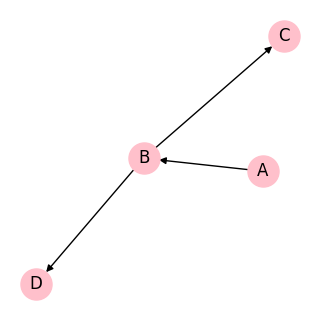

In [2]:
import networkx as nx 
import matplotlib.pyplot as plt 

# creating an directed graph
G = nx.DiGraph()

# adding a node
G.add_node('A')
 
# adding some edges (nodes will also be added if not present)
G.add_edge('A', 'B')
G.add_edge('B', 'C')
G.add_edge('B', 'D')

# drawing our graph
fig = plt.figure(1, figsize=(3, 3))
pos = nx.spring_layout(G, k=0.7)
_ = nx.draw(G, pos=pos, with_labels=True, node_size=500, node_color='pink')

For ***undirected*** graphs, we can get all edges from a query node using <small>`G.edges(node)`</small>.<br>
For ***directed*** graphs, we differentiate between edges pointing ***to*** a query node, and those pointing ***from*** a query node. 

In [3]:
print(G.in_edges('B'))
print(G.out_edges('B'))

[('A', 'B')]
[('B', 'C'), ('B', 'D')]


We can add data to edges, such as a label. <br>
We will need this when building our de bruijn graphs. 

Edge data can be added when an edge is added to the graph, or on existing edges by accessing their data. 

> **Note** <br>
> nx.spring_layout is not deterministic, so rerun the cell below if the graph doesn't look good. <br><br>

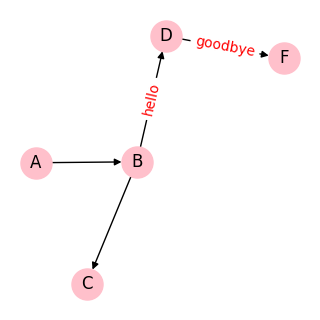

In [4]:
# adding edge with 'label' attribute
G.add_edge('D', 'F', label='goodbye')

# updating edge data with 'label' attribute
G.edges['B', 'D']['label'] = 'hello'

# drawing our graph
fig = plt.figure(1, figsize=(3, 3))
pos = nx.spring_layout(G, k=0.7)
nx.draw(G, pos=pos, with_labels=True, node_size=500, node_color='pink')
_ = nx.draw_networkx_edge_labels(G, pos=pos, edge_labels={e: G.edges[e]['label'] for e in G.edges() if 'label' in G.edges[e]}, font_color='red')

We can access edge data using the following approaches.

In [ ]:
# accessing single attribute for a single edge
G.edges['B', 'D']['label']

In [ ]:
# accessing all attributes for a single edge
G.edges['D', 'F']

In [ ]:
# getting all data on out_edges from node 'B' 
for node1, node2, data in G.out_edges('B', data=True):
    print(node1, node2, data)


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

### Exercise 1: Extract kmers from reads

<b>Challenge:</b> Complete the function below to return all <b>unique</b> k-mers from a set of input strings. 

- [ ] Input: list of reads (str), kmer len k (int)
- [ ] Output: All unique kmers (set)
    
</div>

In [5]:
def get_all_kmers(reads: list[str], k: int) -> set:
    '''
    Return a set of all k-mers of length k from a set of input reads. 
    '''
    kmers = set()
    for read in reads:
        for i in range(len(read) - k + 1):
            kmers.add(read[i:i+k])
    return kmers

In [6]:
# Should return the following
# _matte
# atners
# atters
# e_matt
# ers_no
# ize_ma
# matner
# matter
# rs_not
# size_m
# ters_n
# tters_
# (i.e. 12 unique kmers)

the_kmers = get_all_kmers(yoda_reads, 6)
[print(x) for x in sorted(list(the_kmers))]
print(f'Total kmer count: {len(the_kmers)}')

_matte
atners
atters
e_matt
ers_no
ize_ma
matner
matter
rs_not
size_m
ters_n
tters_
Total kmer count: 12


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

### Exercise 2: Build a Directed Graph

<b>Challenge:</b> Given a set of reads and a value k, build a directed graph using networkx

De Bruin graph nodes are k-1 prefixes/suffixes, and edges represent kmers. <br>
Use the <small>`"label"`</small> data attribute when annotating edges with their kmer. 

- [ ] Input: reads (list of str), k (int)
- [ ] Output: populated graph (nx.DiGraph)

Follow this procedure:
- Initialise a nx.DiGraph()
- Extract all kmers by calling your exercise 1 function
- For each kmer, extract the prefix & suffix, then add an edge to the DiGraph. 

For the kmer AGGTA, the prefix is **AGGT**A and the suffix is A**GGTA**

</div>


In [7]:
def build_graph(reads: list[str], k: int):
    '''
    Given a set of reads and a value k, generate & return a de Bruijn graph represented in networkx.
    Nodes are kmer-1 prefixes / suffixes, and edges represent kmers. 
    '''
    G = nx.DiGraph()
    kmers = get_all_kmers(reads, k)
    for kmer in kmers:
        prefix = kmer[:-1]
        suffix = kmer[1:]
        G.add_edge(prefix, suffix, label=kmer)
    return G


Let's build graphs for our test data and inspect them with the plotting function below.

In [8]:
# helper func to render
def draw_debruijn(graph):
    fig = plt.figure(1, figsize=(16, 8), dpi=60)
    pos = nx.spring_layout(graph, seed=2, k=0.1, iterations=50)
    nx.draw_networkx_nodes(graph, pos, node_color='white', node_size=1000, edgecolors='black', linewidths=1)
    nx.draw_networkx_edges(graph, pos, width=1, arrows=True, arrowstyle='-|>', arrowsize=12, min_target_margin=22)
    nx.draw_networkx_labels(graph, pos, font_size=12, font_family="sans-serif")
    nx.draw_networkx_edge_labels(
        graph, pos, font_color='red', font_size=12, label_pos=0.6,
        verticalalignment='top', horizontalalignment='right',
        edge_labels={e: graph.edges[e]['label'] for e in graph.edges}
    )
    plt.tight_layout()
    plt.show()

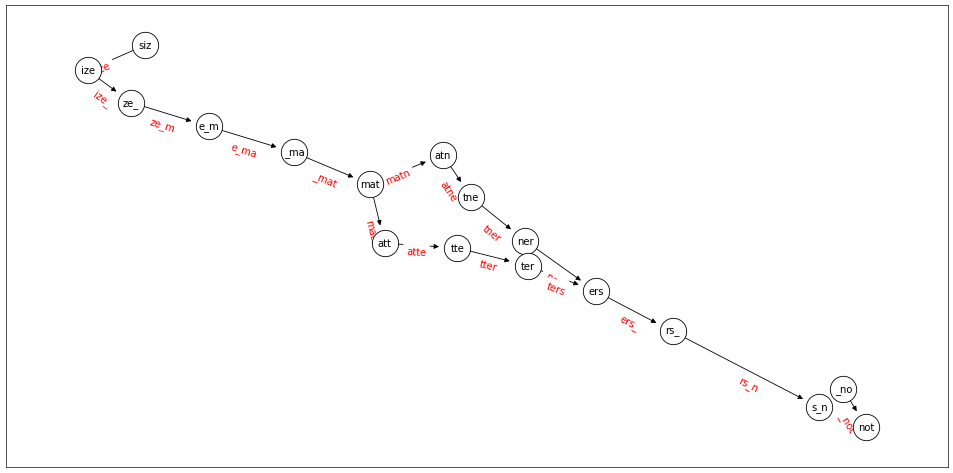

In [9]:
yoda_graph = build_graph(yoda_reads, 4)
draw_debruijn(yoda_graph)

<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

### Exercise 3: Extracting a single contig from de Bruijn Graph

<b>Challenge:</b> Extract a single contig by walking along edges while the path is a linear chain of nodes.  

- [ ] Input: de Bruijn graph (nx.DiGraph) 
- [ ] Output: single contig sequence (str)

Process:
- To begin, find a node with no in-edges. This should only be a single node in our graph. 
- From this node, walk edges, updating the contig sequence. 
- Stop when there are no next edges, or there is a branch point (2+ edges).

Keep in mind that the kmers on edge labels are sequential: eg 

```
kmers:  APPL
         PPLE
          PLES
        ------
contig: APPLES
```

You can get the number of in-edges to a node using the following. <br>
- <small>`G.in_degree(node)`</small>

You can get a list of the edges from a <small>`node`</small> using the following. <br>
- <small>`edges = list(G.out_edges(node, data=True))`</small>

The kmer on each edge should be present as the <small>`"label"`</small> attribute. 
</div>



In [12]:
def extract_contig(G: nx.DiGraph) -> str:
    """
    Extract a single contig from a de Bruijn graph
    """
    for nodes in G.nodes():
        if G.in_degree(nodes) == 0:
            start_node = nodes
            break
    contig = start_node
    current_node = start_node
    while True:
        out_edges = list(G.out_edges(current_node, data=True))
        if len(out_edges) == 0 or len(out_edges) > 1:
            break
        # assuming only one outgoing edge
        _, next_node, edge_data = out_edges[0]
        contig += edge_data['label'][-1]
        current_node = next_node
    return contig


In [13]:
# should print 'size_mat'
extract_contig(yoda_graph)

'size_mat'

<div style="background: rgb(255,165,0); border: solid 1px rgb(129,199,132); padding: 10px;">    

<h1>Extension</h1>

</div>

**Extracting all contigs**

In the function above, we have only extracted one contig, using our "node with no in-edges" logic to begin a walk. 

We're not quite done, as the example de Bruijn graph should actually yield 4 contigs.<br>
This is because we have not addressed the branch point at node 'mat', and merge at node 'ers'.

We could approach this in a number of ways, but in this tutorial we will use the following approach:
- Identify ***all*** nodes which should start contigs
- Walk each to extract the sequence.

**Identifying start nodes**

There are therefore three rules for identifying starting nodes. 
1. If a node has no in-edges (as previous), ***this node*** is a starting node. 
2. If a node has multiple out-edges, ***each child node*** is a starting node.
3. If a node has multiple in-edges, ***this node*** is a starting node. 

The following will help you identify start nodes:
- <small>`G.in_degree(node)`</small>
- <small>`G.out_degree(node)`</small>
- <small>`G.neighbors(node)`</small>
- <small>`G.predecessors(node)`</small>

**Walking edges**

One extra condition for our walk is related to the merge at node 'ers'.<br>
This node is a contig start, so if we encounter this node during another walk (ie walking from 'ter' to 'ers'), we should stop our traversal.  


<div style="color: rgb(27,94,32); background: rgb(200,230,201); border: solid 1px rgb(129,199,132); padding: 10px;">

### Exercise 4: Extracting all contigs from de Bruijn Graph

<b>Challenge:</b> Extract all contigs.

- [ ] Input: de Bruijn graph (nx.DiGraph) 
- [ ] Output: contig sequences (list of str)

Copy and paste your solution from Exercise 3, then add additional logic to handle multiple contigs. 

Process:
- Find all contig start nodes
- Walk each to extract the contig sequence. 

</div>



In [34]:
def extract_all_contigs(G: nx.DiGraph) -> list[str]:
    """
    Extracts all contigs from a de Bruijn graph.
    """
    start_nodes = []
    for node in G.nodes():
        if G.in_degree(node) == 0 or G.in_degree(node) > 1:
            start_nodes.append(node)
        elif G.out_degree(node) > 1:
            child_nodes = list(G.successors(node))
            start_nodes += child_nodes
    
    contigs = []
    for start in start_nodes:
        contig = start
        current_node = start
        while True:
            out_edges = list(G.out_edges(current_node, data=True))
            if len(out_edges) == 0 or any(succ in start_nodes for succ in G.successors(current_node)):
                break
            # assuming only one outgoing edge
            _, next_node, edge_data = out_edges[0]
            contig += edge_data['label'][-1]
            current_node = next_node
        contigs.append(contig)
    return contigs
            

            


In [35]:
# should print ['ers_not', 'atner', 'atter', 'size_mat']
extract_all_contigs(yoda_graph)

['atner', 'atter', 'ers_not', 'size_mat']